# Applied Machine Learning with Face Mask Detection 

### 1. Data pre-processing 
### 2. Exploratory data analysis
### 3. Image Augmentation
### 4. Transfer learning and model building with Keras
### 5. Analysis and evaluation 

In [1]:
!pip install tensorflow
!pip install imutils
!pip install opencv-python

In [2]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
from numpy import expand_dims
import pandas as pd
import random
from pathlib import Path
from IPython.display import display
from PIL import Image
import pickle

### 1. (Data Pre-processing) Creating training and testing image arrays and label arrays

In [3]:
# getting image path of each image in the training data set:

train_data_folder = Path("data/train")

train_csv_df = pd.DataFrame(pd.read_csv("data/train.csv"))
train_csv_df.head()
for i in train_csv_df:
    train_csv_df['filepath'] = train_data_folder / train_csv_df['filename']
    
    

In [4]:
train_csv_df.head()

filename      class                      filepath
0    0-with-mask.jpg  with_mask    data/train/0-with-mask.jpg
1   10-with-mask.jpg  with_mask   data/train/10-with-mask.jpg
2  100-with-mask.jpg  with_mask  data/train/100-with-mask.jpg
3  101-with-mask.jpg  with_mask  data/train/101-with-mask.jpg
4  103-with-mask.jpg  with_mask  data/train/103-with-mask.jpg

In [5]:
# converting all images into arrays and loading them into an array or arrays:

train_images_array = []
for i in range(1178):
    z= image.load_img(train_csv_df["filepath"][i],target_size=(300,300))
    r = image.img_to_array(z)
    r = preprocess_input(r)
    train_images_array.append(r)

train_images_array = np.array(train_images_array)


# making array of training data labels:
train_labels = []
for row in range(1178):
    if train_csv_df["class"][row] == 'with_mask':
        y= [1.0, 0.0]
    else:
        y=[0.0, 1.0]
    
    train_labels.append(y)

    train_labels_array = np.array(train_labels,dtype="float32")
    

In [6]:
# Testing dataset 
# (doing the same thing that we did for the training dataset)

test_data_folder = Path("data/test")

test_csv_df = pd.DataFrame(pd.read_csv("data/test.csv"))
for i in test_csv_df:
    test_csv_df['filepath'] = test_data_folder / test_csv_df['filename']
    
test_images_array = []
for i in range(194):
    z= image.load_img(test_csv_df["filepath"][i],target_size=(224,224))
    r = image.img_to_array(z)
    r = preprocess_input(r) 
    test_images_array.append(r)

test_images_array = np.array(test_images_array)



test_labels_array = []
for row in range(194):
    if test_csv_df["class"][row] == 'with_mask':
        y= [1.0, 0.0]
    else:
        y=[0.0, 1.0]
    
    test_labels_array.append(y)

test_labels_array = np.array(test_labels_array,dtype="float32")

#### 1.1 Visualizing the numerical form of images

In [7]:
train_images_array

array([[[[-0.5294118 , -0.4823529 , -0.7019608 ],
         [-0.60784316, -0.5372549 , -0.7490196 ],
         [-0.654902  , -0.5921569 , -0.77254903],
         ...,
         [-0.58431375, -0.5529412 , -0.73333335],
         [-0.75686276, -0.70980394, -0.92941177],
         [-0.8117647 , -0.78039217, -0.9137255 ]],

        [[-0.5529412 , -0.5058824 , -0.7254902 ],
         [-0.6156863 , -0.54509807, -0.75686276],
         [-0.64705884, -0.58431375, -0.7647059 ],
         ...,
         [-0.654902  , -0.6156863 , -0.79607844],
         [-0.7411765 , -0.69411767, -0.8980392 ],
         [-0.8117647 , -0.75686276, -0.8980392 ]],

        [[-0.5921569 , -0.54509807, -0.7647059 ],
         [-0.6313726 , -0.56078434, -0.77254903],
         [-0.64705884, -0.58431375, -0.7647059 ],
         ...,
         [-0.7647059 , -0.7254902 , -0.8980392 ],
         [-0.7490196 , -0.6862745 , -0.8745098 ],
         [-0.7882353 , -0.7176471 , -0.8509804 ]],

        ...,

        [[-0.56078434, -0.44313723, -0

### 2. Exploratory data analysis
#### 2.1 Sampling and visually inspecting 20 images

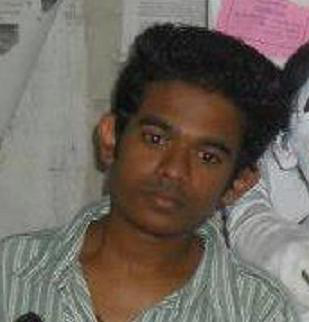

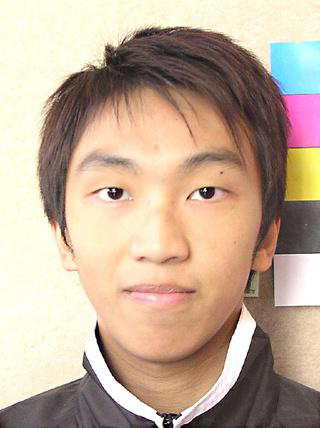

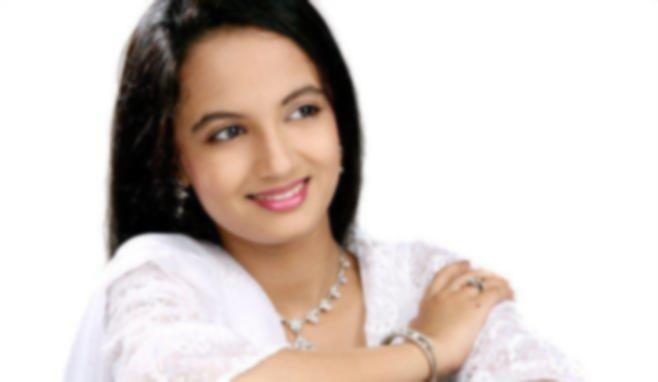

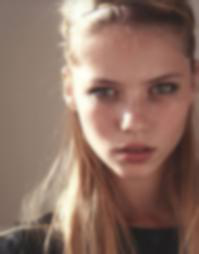

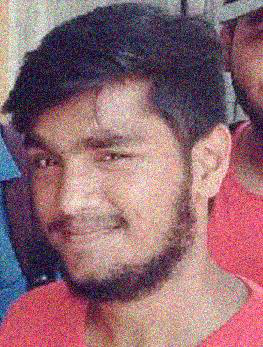

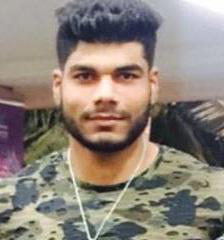

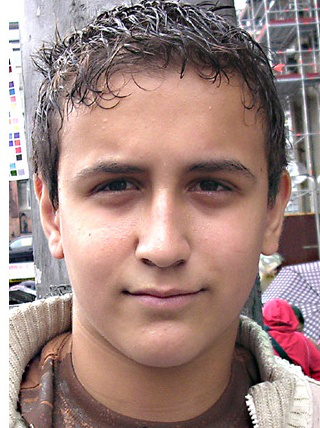

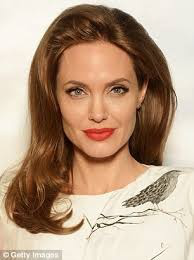

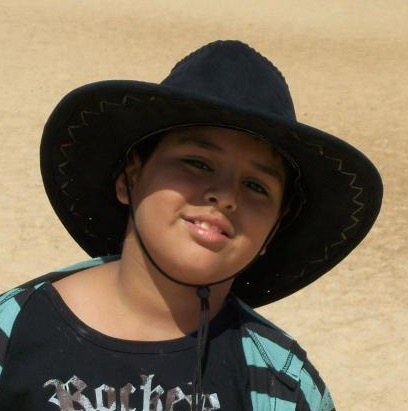

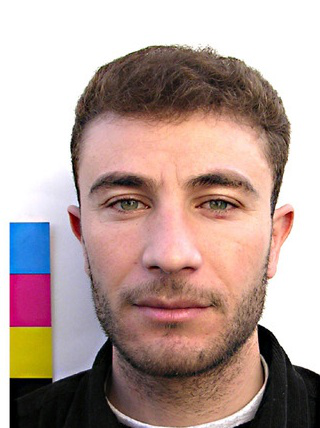

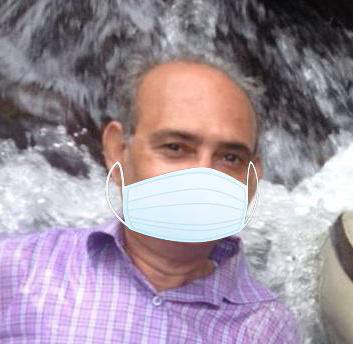

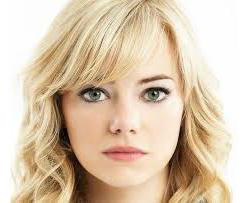

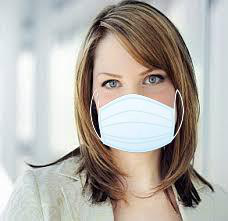

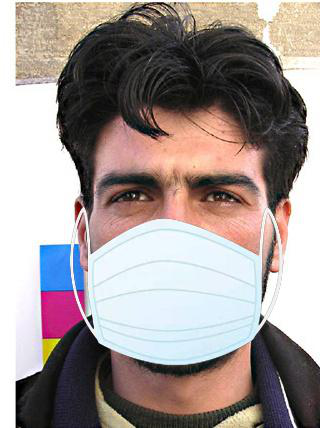

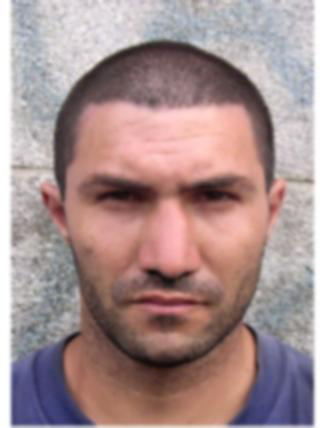

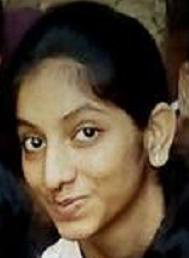

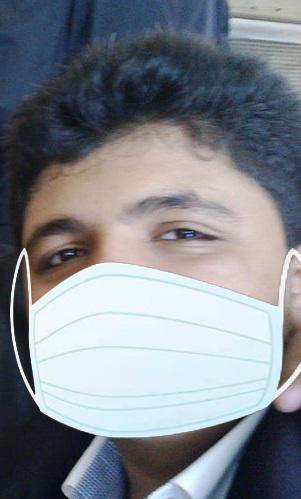

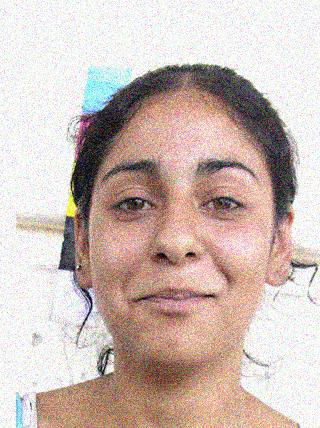

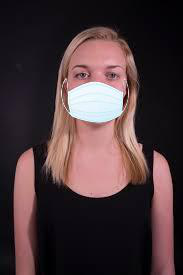

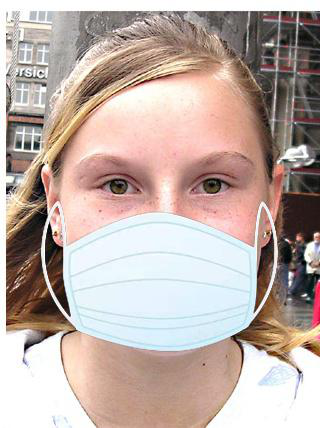

In [8]:
# Sampling and visually inspecting 20 images:

import random
for i in random.sample(range(1178), 20):
    display(Image.open(train_csv_df['filepath'][i]))
    

#### 2.2 Checking for class imbalance

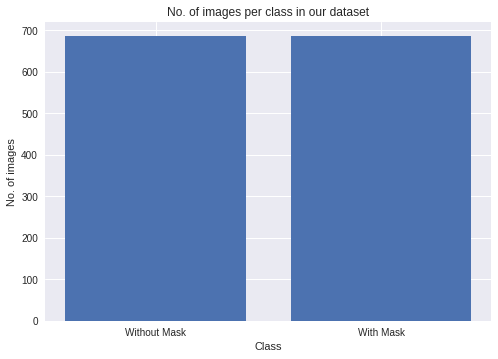

In [9]:
# Checking for class imbalance in dataset

num_mask= 0
num_no_mask = 0

labels = ["Without Mask", "With Mask"]

for row in range(1178):
    if train_csv_df["class"][row] == 'with_mask':
        num_mask +=1
    else:
        num_no_mask +=1

for row in range(194):
    if test_csv_df["class"][row] == 'with_mask':
        num_mask +=1
    else:
        num_no_mask +=1

num_classes = [num_no_mask, num_mask]
     
plt.bar(labels, num_classes)
plt.title("No. of images per class in our dataset")
plt.xlabel("Class")
plt.ylabel("No. of images")
plt.show()



### 3. Data Augmentation


#### 3.1 Visualizing various image augmentations

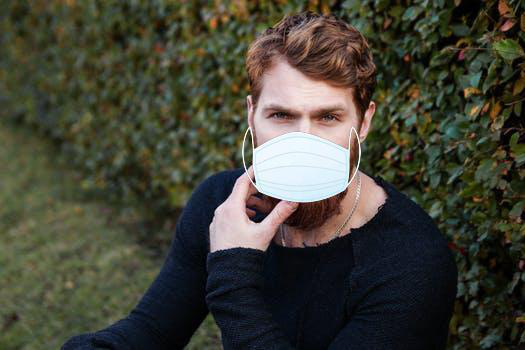

In [10]:
# We will be visualizing augmentations on the following image:

img_to_aug = Path("data/train/0-with-mask.jpg")
load_img(img_to_aug)

#### a) Horizontal Shifts

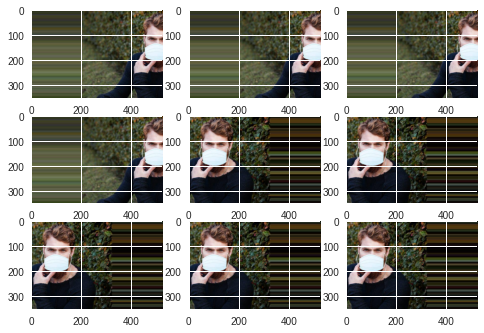

In [11]:
# Visualizing data agumentations:
# Horizontal shifts

img_to_aug = img_to_array(load_img(img_to_aug))
img_to_aug = expand_dims(img_to_aug, 0)

width_shift = ImageDataGenerator(width_shift_range=[-200,200])

it = width_shift.flow(img_to_aug, batch_size=1)

for i in range(9):

    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')    
    plt.imshow(image)
    
plt.show()


#### b) Horizontal and vertical flips

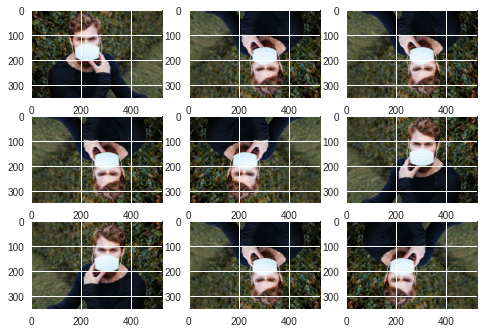

In [12]:
# Visualizing data agumentations:
# Horizontal and vertical flips
flips = ImageDataGenerator(horizontal_flip=True, 
                            vertical_flip=True)

it = flips.flow(img_to_aug, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()

#### c) Random rotation

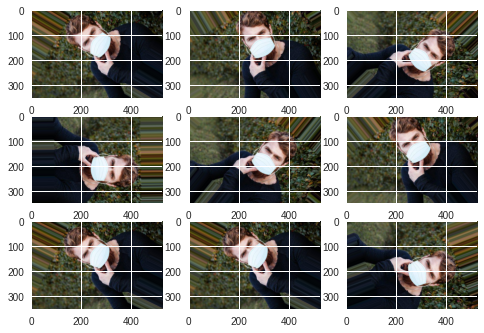

In [13]:
# Visualizing data agumentations:
# Random rotation

rand_rot = ImageDataGenerator(rotation_range=90)

it = rand_rot.flow(img_to_aug, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()

#### d) Random zooming

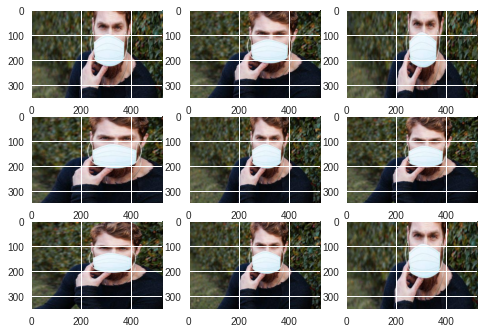

In [14]:
# Visualizing data agumentations:
# Random zooming

rand_zoom = ImageDataGenerator(zoom_range=[0.5,1.0])

it = rand_zoom.flow(img_to_aug, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()

#### 3.2 Creating the image augmenter for our model

In [15]:
# creating the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### 4. Building transfer learning model with Keras

##### Adapted from PyImageSearch by Adrian Rosebrock 

In [16]:
# Loading the MobileNetV2 network, with the topmost layer removed

base_model = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))


# Freeze the layer of the base model to make them untrainable.
# This ensures that their weights are not updated when we train the model.

for layer in base_model.layers:
    layer.trainable = False
    
    
# Construct head of the model that will be attached on top of the base model:

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)


# Combine the head and base of the models together:

my_model = Model(inputs=base_model.input, outputs=head_model)


In [17]:
# initializing initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [18]:

# Compiling the model:

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
my_model.compile(loss="binary_crossentropy", optimizer=opt,
                metrics=["accuracy"])


In [20]:
# Training of the model:
# do not run this cell as training will take long so we will import a model in the next cell

history = my_model.fit(
    aug.flow(train_images_array, train_labels_array, batch_size=BS),
    steps_per_epoch=len(train_images_array) // BS,
    validation_data=(test_images_array, test_labels_array),
    validation_steps=len(test_images_array)//BS,
    epochs=EPOCHS)



Epoch 1/20
36/36 [==============================] - 24s 674ms/step - loss: 0.4682 - accuracy: 0.7478 - val_loss: 0.1172 - val_accuracy: 0.9897
Epoch 2/20
36/36 [==============================] - 23s 643ms/step - loss: 0.4713 - accuracy: 0.7609 - val_loss: 0.1316 - val_accuracy: 0.9897
Epoch 3/20
36/36 [==============================] - 24s 673ms/step - loss: 0.4748 - accuracy: 0.7670 - val_loss: 0.1302 - val_accuracy: 0.9897
Epoch 4/20
36/36 [==============================] - 24s 666ms/step - loss: 0.4502 - accuracy: 0.7705 - val_loss: 0.1262 - val_accuracy: 0.9897
Epoch 5/20
36/36 [==============================] - 24s 656ms/step - loss: 0.4547 - accuracy: 0.7696 - val_loss: 0.1174 - val_accuracy: 0.9948
Epoch 6/20
36/36 [==============================] - 24s 671ms/step - loss: 0.4383 - accuracy: 0.7696 - val_loss: 0.1083 - val_accuracy: 0.9948
Epoch 7/20
36/36 [==============================] - 24s 675ms/step - loss: 0.4322 - accuracy: 0.7914 - val_loss: 0.1109 - val_accuracy: 0.9897

# Let's save our model and training history

In [ ]:
# Save our model training history for future analysis

# with open("./history.pickle",'wb') as f:
#     pickle.dump(history.history, f)

# Save our model weights

# my_model.save("model")

#### Loading the model we have given to you

In [ ]:
from tensorflow import keras
reloaded_model = keras.models.load_model("model")

In [ ]:
# Testing accurcay of our model using our testing dataset:

results = reloaded_model.evaluate(test_images_array, test_labels_array, batch_size=128)

#### *In the above cell, you might have noticed that we have used the validation set as the final evaluation set. This is just for demonstration and ideally, you would use a separate datsest for the final evaluation.*

### 5. Analysis and Evaluation:
#### Plotting training and validation accuracy and loss curves

In [ ]:
# first, let's load the saved training history

with open("./history.pickle",'rb') as f:
    training_history = pickle.load(f)
    
# you'd typically instead use history.history[..] instead of training_history[..] but today we've
# provided the training_history file for you since training the model and generating the
# history takes a while...

In [ ]:
# Obtaining values of accuracy and loss for training and validation data in each epoch:

train_acc = training_history['accuracy']
val_acc = training_history['val_accuracy']

train_loss = training_history['loss']
val_loss = training_history['val_loss']

num_epochs = range(len(train_acc))

In [ ]:
# plotting training and validation accuracy graph:

plt.plot(num_epochs, train_acc)
plt.plot(num_epochs, val_acc)
plt.title("Training and validation accuracy")
plt.figure()